<a href="https://colab.research.google.com/github/MonirulIslamm08/Nurse-Scheduling/blob/main/Stable_and_Feasible_Nurse_Scheduling_Optimization_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 96.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from pulp import *
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [5]:
 patient_demand = pd.read_excel("/content/patient_demand.xlsx")
 nurses = pd.read_excel('/content/nurses.xlsx')
 shift_templates = pd.read_csv('/content/shift_templates.csv')

In [10]:
patient_demand.head()


,date,unit,shift,patient_count,acuity_low,acuity_medium,acuity_high,required_RN
0,2025-04-21,AdultOnc,D,30,12,12,6,3
1,2025-04-21,AdultOnc,E,30,12,12,6,3
2,2025-04-21,AdultOnc,N,30,12,12,6,3
3,2025-04-21,PedsOnc,D,15,6,6,3,2
4,2025-04-21,PedsOnc,E,15,6,6,3,2


In [11]:
nurses.head()

,nurse_id,unit,grade,years_experience,skills,fte,preferred_shifts,weekend_off_pattern
0,N101,RadTher,RN1,8,ICU,1.0,E,Every other
1,N102,ICU,RN2,14,"Peds,Chemo",0.8,E,Every other
2,N103,PedsOnc,RN3,2,"Peds,Chemo",1.0,N,Every other
3,N104,AdultOnc,RN2,6,IV,0.8,D,2-on-1-off
4,N105,AdultOnc,RN2,12,"Chemo,Peds",0.8,"D,E,N",Every other


In [12]:
shift_templates.head()

,shift_code,start_time,end_time,hours
0,D,07:00,15:00,8
1,E,15:00,23:00,8
2,N,23:00,07:00,8


In [13]:
# Group by unit and get the preferred skills and total nurses.
unit_wise_skills = nurses.groupby('unit')['skills'].apply(list).reset_index()
unit_wise_total_nurses = nurses.groupby('unit')['nurse_id'].count().reset_index()

# Rename columns for clarity
unit_wise_skills = unit_wise_skills.rename(columns={'skills': 'preferred_skills'})
unit_wise_total_nurses = unit_wise_total_nurses.rename(columns={'nurse_id': 'total_nurses'})

# Merge the two dataframes to combine preferred skills and total nurses
result = pd.merge(unit_wise_skills, unit_wise_total_nurses, on='unit')
result


,unit,preferred_skills,total_nurses
0,AdultOnc,"[IV, Chemo,Peds, IV,Chemo, Radiotherapy,Chemo,...",18
1,ICU,"[Peds,Chemo, Chemo, Peds,Radiotherapy, Radioth...",12
2,PedsOnc,"[Peds,Chemo, Radiotherapy, Peds,Radiotherapy, ...",13
3,RadTher,"[ICU, IV,ICU, IV, Radiotherapy,Peds, ICU, ICU,...",11


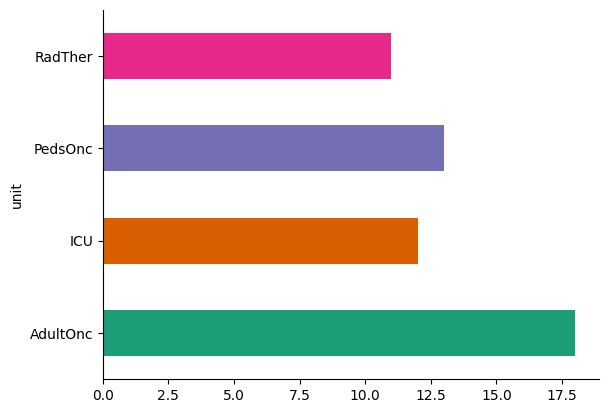

In [14]:
from matplotlib import pyplot as plt
import seaborn as sns
nurses.groupby('unit').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# preferred_shifts

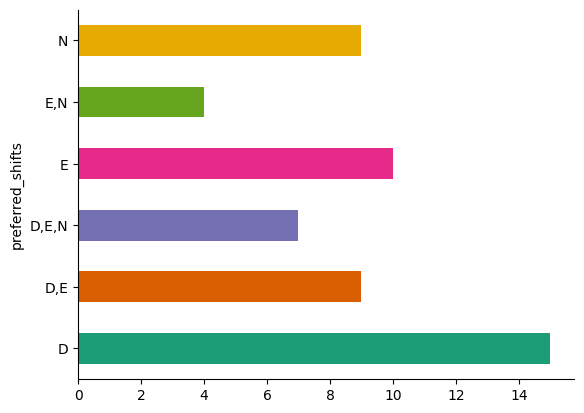

In [15]:
from matplotlib import pyplot as plt
import seaborn as sns
nurses.groupby('preferred_shifts').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [16]:

nurse_counts = nurses.groupby('weekend_off_pattern')['nurse_id'].count()

nurse_counts


,nurse_id
weekend_off_pattern,
2-on-1-off,38
Every other,16


In [17]:
patient_demand.tail()

,date,unit,shift,patient_count,acuity_low,acuity_medium,acuity_high,required_RN
79,2025-04-27,ICU,E,10,4,4,2,2
80,2025-04-27,ICU,N,10,4,4,2,2
81,2025-04-27,RadTher,D,12,4,4,4,2
82,2025-04-27,RadTher,E,12,4,4,4,2
83,2025-04-27,RadTher,N,12,4,4,4,2


In [20]:
patient_demand['day_of_week'] = patient_demand['date'].dt.day_name()
patient_demand['is_weekend'] = patient_demand['date'].dt.dayofweek.isin([5, 6])
patient_demand[['day_of_week', 'is_weekend']]


,day_of_week,is_weekend
0,Monday,False
1,Monday,False
2,Monday,False
3,Monday,False
4,Monday,False
...,...,...
79,Sunday,True
80,Sunday,True
81,Sunday,True
82,Sunday,True


In [21]:
patient_demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           84 non-null     datetime64[ns]
 1   unit           84 non-null     object        
 2   shift          84 non-null     object        
 3   patient_count  84 non-null     int64         
 4   acuity_low     84 non-null     int64         
 5   acuity_medium  84 non-null     int64         
 6   acuity_high    84 non-null     int64         
 7   required_RN    84 non-null     int64         
 8   day_of_week    84 non-null     object        
 9   is_weekend     84 non-null     bool          
dtypes: bool(1), datetime64[ns](1), int64(5), object(3)
memory usage: 6.1+ KB


In [22]:
num_days = len(patient_demand['date'].unique())

print(f"Number of unique dates (days) in the dataset: {num_days}")


Number of unique dates (days) in the dataset: 7


In [23]:
# Group the data by unit and calculate the sum of required_RN for each unit.
unit_wise_required_RN = patient_demand.groupby('unit')['required_RN'].sum()

unit_wise_required_RN


,required_RN
unit,
AdultOnc,63
ICU,42
PedsOnc,42
RadTher,42


In [24]:
daily_total_required_RN = patient_demand.groupby('date')['required_RN'].sum()

daily_total_required_RN

,required_RN
date,
2025-04-21,27
2025-04-22,27
2025-04-23,27
2025-04-24,27
2025-04-25,27
2025-04-26,27
2025-04-27,27


In [25]:
#  daily required_RN per unit
daily_required_RN = patient_demand.groupby(['unit', 'date'])['required_RN'].sum().reset_index()
daily_required_RN = daily_required_RN.groupby('unit')['required_RN'].mean().reset_index()
daily_required_RN = daily_required_RN.rename(columns={'required_RN': 'avg_daily_required_RN'})

daily_required_RN


,unit,avg_daily_required_RN
0,AdultOnc,9.0
1,ICU,6.0
2,PedsOnc,6.0
3,RadTher,6.0


In [26]:
weekly_required_RN = patient_demand.groupby(['unit', pd.Grouper(key='date', freq='W')])['required_RN'].sum().reset_index()
weekly_required_RN



,unit,date,required_RN
0,AdultOnc,2025-04-27,63
1,ICU,2025-04-27,42
2,PedsOnc,2025-04-27,42
3,RadTher,2025-04-27,42


In [27]:
# prompt: so weekly  available_nurses per unit in dataset

weekly_available_nurses = nurses.groupby(['unit', 'weekend_off_pattern'])['nurse_id'].count().reset_index()
weekly_available_nurses = weekly_available_nurses.rename(columns={'nurse_id': 'available_nurses'})
weekly_available_nurses = weekly_available_nurses.groupby('unit')['available_nurses'].mean().reset_index()
weekly_available_nurses


,unit,available_nurses
0,AdultOnc,9.0
1,ICU,6.0
2,PedsOnc,6.5
3,RadTher,5.5


In [28]:
from re import A
icu_nurses = weekly_available_nurses[weekly_available_nurses['unit'] == 'ICU']
AdultOnc_nurses = weekly_available_nurses[weekly_available_nurses['unit'] == 'AdultOnc']
PedsOnc_nurses = weekly_available_nurses[weekly_available_nurses['unit'] == 'PedsOnc']
RadTher_nurses = weekly_available_nurses[weekly_available_nurses['unit'] == 'RadTher']





In [29]:

total_available_ICU_nurses = icu_nurses['available_nurses'].sum()
total_available_AdultOnc_nurses = AdultOnc_nurses['available_nurses'].sum()
total_available_PedsOnc_nurses = PedsOnc_nurses['available_nurses'].sum()
total_available_RadTher_nurses = RadTher_nurses['available_nurses'].sum()


# Print the result
print(f"Weekly available ICU nurses: {total_available_ICU_nurses}")
print(f"Weekly available AdaltOns nurses: {total_available_AdultOnc_nurses}")
print(f"Weekly available PedsOns nurses: {total_available_PedsOnc_nurses}")
print(f"Weekly available RedTher nurses: {total_available_RadTher_nurses}")


Weekly available ICU nurses: 6.0
Weekly available AdaltOns nurses: 9.0
Weekly available PedsOns nurses: 6.5
Weekly available RedTher nurses: 5.5


In [30]:
# Group by unit and calculate the average weekly required nurses.
avg_weekly_required_RN = weekly_required_RN.groupby('unit')['required_RN'].mean().reset_index()
avg_weekly_required_RN = avg_weekly_required_RN.rename(columns={'required_RN': 'avg_weekly_required_RN'})

# Merge with weekly_available_nurses to have both required and available nurses in one table
weekly_staffing = pd.merge(avg_weekly_required_RN, weekly_available_nurses, on='unit', how='left')


# Display the merged dataframe
print(weekly_staffing)


# Group by unit and weekend_off_pattern to see the distribution of nurses.
nurses_by_pattern = nurses.groupby(['unit', 'weekend_off_pattern'])['nurse_id'].count().reset_index()
nurses_by_pattern = nurses_by_pattern.rename(columns={'nurse_id': 'nurse_count'})


# Function to get the number of nurses per unit per week based on the weekend_off_pattern.
def nurses_per_unit_per_week(unit_name):
  unit_data = nurses_by_pattern[nurses_by_pattern['unit'] == unit_name]

  total_nurses = unit_data['nurse_count'].sum()  #Total nurses in a unit
  weekend_off_pattern_counts = unit_data.set_index('weekend_off_pattern')['nurse_count'].to_dict() #Count of nurses based on pattern

  return total_nurses, weekend_off_pattern_counts


# Get the number of nurses for each unit
units = ['ICU', 'AdultOnc', 'PedsOnc', 'RadTher']
for unit in units:
  total_nurses, weekend_off_pattern_counts = nurses_per_unit_per_week(unit)
  print(f"Total nurses needed for {unit} per week: {total_nurses}") # Based on total counts from weekend_off_pattern
  print(f"Distribution by weekend off pattern:{weekend_off_pattern_counts}")


       unit  avg_weekly_required_RN  available_nurses
0  AdultOnc                    63.0               9.0
1       ICU                    42.0               6.0
2   PedsOnc                    42.0               6.5
3   RadTher                    42.0               5.5
Total nurses needed for ICU per week: 12
Distribution by weekend off pattern:{'2-on-1-off': 7, 'Every other': 5}
Total nurses needed for AdultOnc per week: 18
Distribution by weekend off pattern:{'2-on-1-off': 14, 'Every other': 4}
Total nurses needed for PedsOnc per week: 13
Distribution by weekend off pattern:{'2-on-1-off': 10, 'Every other': 3}
Total nurses needed for RadTher per week: 11
Distribution by weekend off pattern:{'2-on-1-off': 7, 'Every other': 4}


In [31]:
weekly_required_RN

,unit,date,required_RN
0,AdultOnc,2025-04-27,63
1,ICU,2025-04-27,42
2,PedsOnc,2025-04-27,42
3,RadTher,2025-04-27,42


In [32]:

weekly_data = pd.merge(weekly_required_RN, weekly_available_nurses, on='unit', how='left')

weekly_data


,unit,date,required_RN,available_nurses
0,AdultOnc,2025-04-27,63,9.0
1,ICU,2025-04-27,42,6.0
2,PedsOnc,2025-04-27,42,6.5
3,RadTher,2025-04-27,42,5.5


# code start

In [33]:
# 1. Enhanced Data Preparation with Cross-Unit Staffing
def prepare_data_with_cross_staffing(patient_demand, nurses, shift_templates):
    """Prepare data allowing for cross-unit staffing in critical cases"""
    # Identify critical shortages
    unit_demands = patient_demand.groupby('unit')['required_RN'].sum()
    unit_nurses = nurses.groupby('unit').size()
    shortage_units = unit_demands / unit_nurses > 3.5  # More than 3.5 shifts/nurse

    # Create float pool nurses (10% of total nurses)
    float_pool_size = max(2, int(len(nurses) * 0.1))
    float_pool = nurses.sample(float_pool_size, random_state=42).copy()
    float_pool['unit'] = 'Float'

    # Combine with original nurses
    enhanced_nurses = pd.concat([nurses, float_pool]) # Combine nurses and float_pool DataFrames
    enhanced_nurses

    # Modify skill requirements for float nurses
    critical_skills = {
        'RadTher': ['Radiotherapy'],
        'ICU': ['ICU'],
        'PedsOnc': ['Peds'],
        'AdultOnc': ['Chemo']
    }

    for unit in shortage_units[shortage_units].index:
        enhanced_nurses.loc[enhanced_nurses['unit'] == 'Float', 'skills'] = \
            enhanced_nurses.loc[enhanced_nurses['unit'] == 'Float', 'skills'].astype(str) + ',' + ','.join(critical_skills.get(unit, []))

    return patient_demand, enhanced_nurses, shift_templates

In [34]:
# 2. Emergency Optimization Setup
def setup_emergency_optimization(patient_demand, nurses, shift_templates):
    """Set up optimization with emergency measures"""
    prob = LpProblem("Emergency_Nurse_Scheduling", LpMinimize)

    # Extract unique values
    dates = sorted(patient_demand['date'].unique())
    units = patient_demand['unit'].unique()
    shifts = shift_templates['shift_code'].unique()
    nurse_ids = nurses['nurse_id'].unique()

    # Create decision variables
    x = LpVariable.dicts(
        "assignment",
        [(nurse_id, day, shift, unit)
         for nurse_id in nurse_ids
         for day in dates
         for shift in shifts
         for unit in (['Float'] if nurses[nurses['nurse_id'] == nurse_id]['unit'].iloc[0] == 'Float'
                    else [nurses[nurses['nurse_id'] == nurse_id]['unit'].iloc[0]])],
        cat='Binary'
    )

    # Soft constraint variables
    under_staff = LpVariable.dicts(
        "under_staff",
        [(day, unit, shift) for day in dates for unit in units for shift in shifts],
        lowBound=0
    )

    cross_staff = LpVariable.dicts(
        "cross_staff",
        [(nurse_id, day, shift, unit)
         for nurse_id in nurse_ids
         for day in dates
         for shift in shifts
         for unit in units
         if nurses[nurses['nurse_id'] == nurse_id]['unit'].values[0] != 'Float' and
         nurses[nurses['nurse_id'] == nurse_id]['unit'].values[0] != unit],
        cat='Binary'
    )

    ## OBJECTIVE FUNCTION ##
    # Priority 1: Minimize understaffing
    # Priority 2: Minimize cross-staffing
    # Priority 3: Respect preferences
    prob += (
        lpSum(1000 * under_staff[(day, unit, shift)] for day in dates for unit in units for shift in shifts) +
        lpSum(500 * cross_staff[(nurse_id, day, shift, unit)] for nurse_id in nurse_ids for day in dates
              for shift in shifts for unit in units
              if (nurse_id, day, shift, unit) in cross_staff) +
        lpSum(-10 * x[(nurse_id, day, shift, unit)]
              for nurse_id in nurse_ids for day in dates
              for shift in shifts for unit in units
              if (nurse_id, day, shift, unit) in x)
    )

    ## CONSTRAINTS ##

    # 1. Cover Patient Demand with emergency measures
    for day in dates:
        for unit in units:
            for shift in shifts:
                req_rn = patient_demand[
                    (patient_demand['date'] == day) &
                    (patient_demand['unit'] == unit) &
                    (patient_demand['shift'] == shift)
                ]['required_RN'].values[0]

                # Original unit nurses + float pool + cross-staffed nurses
                prob += (
                    lpSum(x[(nurse_id, day, shift, unit)]
                          for nurse_id in nurse_ids
                          if ((nurse_id, day, shift, unit) in x and
                              (nurses[nurses['nurse_id'] == nurse_id]['unit'].values[0] == unit or
                               nurses[nurses['nurse_id'] == nurse_id]['unit'].values[0] == 'Float'))) +
                    lpSum(cross_staff[(nurse_id, day, shift, unit)]
                          for nurse_id in nurse_ids
                          if (nurse_id, day, shift, unit) in cross_staff) +
                    under_staff[(day, unit, shift)] >= req_rn
                )

                # Allow up to 30% understaffing in emergencies
                prob += under_staff[(day, unit, shift)] <= 0.3 * req_rn

    # 2. Limit cross-staffing (max 2 shifts per nurse cross-staffed)
    for nurse_id in nurse_ids:
        if nurses[nurses['nurse_id'] == nurse_id]['unit'].values[0] != 'Float':
            prob += lpSum(
                cross_staff[(nurse_id, day, shift, unit)]
                for day in dates
                for shift in shifts
                for unit in units
                if (nurse_id, day, shift, unit) in cross_staff
            ) <= 2

    # 3. Core constraints (simplified for emergency)
    for nurse in nurses.itertuples():
        # Max 5 consecutive working days
        for i in range(len(dates)-4):
            prob += lpSum(
                x.get((nurse.nurse_id, dates[i+j], s, nurse.unit),0)
                for j in range(5)
                for s in shifts
            ) + lpSum(
                cross_staff.get((nurse.nurse_id, dates[i+j], s, u),0)
                for j in range(5)
                for s in shifts
                for u in units
                if (nurse.nurse_id, dates[i+j], s, u) in cross_staff
            ) <= 4

        # Max 1 shift per day
        for day in dates:
            prob += lpSum(
                x.get((nurse.nurse_id, day, s, nurse.unit),0)
                for s in shifts
            ) + lpSum(
                cross_staff.get((nurse.nurse_id, day, s, u),0)
                for s in shifts
                for u in units
                if (nurse.nurse_id, day, s, u) in cross_staff
            ) <= 1

    return prob, x, cross_staff, under_staff, dates

#  Solve and Extract Solution


In [35]:
# 3. Emergency Solution Execution
def execute_emergency_solution():
    # Load original data
    patient_demand = pd.read_excel('/content/patient_demand.xlsx')
    nurses = pd.read_excel('/content/nurses.xlsx')
    shift_templates = pd.read_csv('/content/shift_templates.csv')

    # Prepare enhanced data
    patient_demand, enhanced_nurses, shift_templates = prepare_data_with_cross_staffing(
        patient_demand, nurses, shift_templates
    )

    # Set up and solve emergency optimization
    prob, x, cross_staff, under_staff, dates = setup_emergency_optimization(
        patient_demand, enhanced_nurses, shift_templates
    )

    # Solve with extended time limit
    prob.solve(PULP_CBC_CMD(timeLimit=300, msg=True))

    if LpStatus[prob.status] != "Optimal":
        print("Emergency measures failed. Manual intervention required.")
        return None, None, None

    # Extract solution
    schedule = []
    cross_staffed = []
    understaffing = []

    for (nurse_id, day, shift, unit), var in x.items():
        if var.varValue == 1:
            schedule.append({
                'nurse_id': nurse_id,
                'date': day,
                'shift': shift,
                'unit': unit,
                'type': 'float' if enhanced_nurses[enhanced_nurses['nurse_id'] == nurse_id]['unit'].values[0] == 'Float' else 'regular'
            })

    for (nurse_id, day, shift, unit), var in cross_staff.items():
        if var.varValue == 1:
            cross_staffed.append({
                'nurse_id': nurse_id,
                'date': day,
                'shift': shift,
                'assigned_unit': unit,
                'home_unit': enhanced_nurses[enhanced_nurses['nurse_id'] == nurse_id]['unit'].values[0]
            })

    for (day, unit, shift), var in under_staff.items():
        if var.varValue > 0:
            understaffing.append({
                'date': day,
                'unit': unit,
                'shift': shift,
                'under_staff': var.varValue
            })

    schedule_df = pd.DataFrame(schedule)
    cross_staff_df = pd.DataFrame(cross_staffed)
    understaff_df = pd.DataFrame(understaffing)

    # Merge with nurse attributes
    schedule_df = pd.merge(
        schedule_df,
        enhanced_nurses[['nurse_id', 'unit', 'skills', 'fte']],
        on='nurse_id'
    )

    return schedule_df, cross_staff_df, understaff_df

In [36]:
# 4. Main Execution with Emergency Measures
if __name__ == "__main__":
    print("=== EMERGENCY SCHEDULING MODE ===")
    print("Implementing cross-unit staffing and float pool...")

    schedule_df, cross_staff_df, understaff_df = execute_emergency_solution()

    if schedule_df is not None:
        print("\n=== EMERGENCY SCHEDULE GENERATED ===")
        print(f"Total assignments: {len(schedule_df)}")
        print(f"Float pool assignments: {len(schedule_df[schedule_df['type'] == 'float'])}")

        if len(cross_staff_df) > 0:
            print(f"\nCross-staffed assignments: {len(cross_staff_df)}")
            print("Cross-staffing by unit:")
            print(cross_staff_df.groupby('assigned_unit').size())

        if len(understaff_df) > 0:
            print(f"\nUnderstaffed shifts: {len(understaff_df)}")
            print("Understaffing by unit:")
            print(understaff_df.groupby('unit')['under_staff'].sum())

        # Save results
        schedule_df.to_csv('emergency_schedule.csv', index=False)
        if len(cross_staff_df) > 0:
            cross_staff_df.to_csv('cross_staffing.csv', index=False)
        if len(understaff_df) > 0:
            understaff_df.to_csv('understaffing.csv', index=False)

        print("\nEmergency schedule saved to CSV files")
    else:
        print("\nFAILED TO GENERATE SCHEDULE. MANUAL INTERVENTION REQUIRED.")

=== EMERGENCY SCHEDULING MODE ===
Implementing cross-unit staffing and float pool...

=== EMERGENCY SCHEDULE GENERATED ===
Total assignments: 354
Float pool assignments: 0

Emergency schedule saved to CSV files


# Analysis and Reporting

# Machine Learning Integration

In [41]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import joblib
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, r2_score

def prepare_data(historical_demand):
    """Prepare data for training with enhanced features"""
    df = historical_demand.copy()

    # Feature engineering
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
    df['is_holiday'] = 0  # Placeholder for holiday feature

    # Historical averages
    unit_shift_avg = df.groupby(['unit','shift'])['required_RN'].mean().to_dict()
    df['unit_shift_avg'] = df.apply(lambda x: unit_shift_avg[(x['unit'],x['shift'])], axis=1)

    # Rolling features
    df['7d_avg'] = df.groupby(['unit','shift'])['required_RN'].transform(lambda x: x.rolling(7, 1).mean())

    return df

def train_model(historical_demand, model_path='demand_model.pkl'):
    """Train and save prediction model with enhanced validation"""
    df = prepare_data(historical_demand)

    # Features and target
    features = pd.get_dummies(df[['unit','shift','day_of_week','month',
                                 'is_weekend','is_holiday','unit_shift_avg','7d_avg']])
    target = df['required_RN']

    # Train-test split with temporal validation
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=42, shuffle=False
    )

    # Train model with hyperparameters
    model = RandomForestRegressor(
        n_estimators=300,
        max_depth=12,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Model Performance - MAE: {mae:.2f}, R2: {r2:.2f}")

    # Save model and metadata
    model_data = {
        'model': model,
        'features': features.columns.tolist(),
        'unit_shift_avg': df.groupby(['unit','shift'])['required_RN'].mean().to_dict(),
        'last_trained': datetime.now(),
        'metrics': {'mae': mae, 'r2': r2}
    }

    joblib.dump(model_data, model_path)
    print(f"Model saved to {model_path}")

    return model_data

if __name__ == "__main__":
    # Load historical data
    historical_demand = pd.read_excel('/content/patient_demand.xlsx')
    historical_demand['date'] = pd.to_datetime(historical_demand['date'])

    # Train and save model
    model_data = train_model(historical_demand)

Model Performance - MAE: 0.00, R2: 1.00
Model saved to demand_model.pkl
